#Setup

First change runtime to GPU for better Deep Learning performance.

In [2]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317130 sha256=180610ce7c74458c98d29730c483ccfe5cb91f1a32e35e1b7478fcf1b9a96f97
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark


In [3]:
import os
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *
from math import radians, cos, sin, asin, sqrt
import datetime
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers as layers
from matplotlib import pyplot as plt

In [5]:
# Initialize Spark
spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

# Download Data

In [4]:
!wget https://www.ncei.noaa.gov/pub/data/ghcn/daily/ghcnd-countries.txt

--2023-05-08 19:45:31--  https://www.ncei.noaa.gov/pub/data/ghcn/daily/ghcnd-countries.txt
Resolving www.ncei.noaa.gov (www.ncei.noaa.gov)... 205.167.25.167, 205.167.25.172, 205.167.25.177, ...
Connecting to www.ncei.noaa.gov (www.ncei.noaa.gov)|205.167.25.167|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3659 (3.6K) [text/plain]
Saving to: ‘ghcnd-countries.txt’

ghcnd-countries.txt 100%[===================>]   3.57K  --.-KB/s    in 0s      

2023-05-08 19:45:31 (181 MB/s) - ‘ghcnd-countries.txt’ saved [3659/3659]



In [5]:
!wget https://www.ncei.noaa.gov/pub/data/ghcn/daily/ghcnd-stations.txt

--2023-05-08 19:45:32--  https://www.ncei.noaa.gov/pub/data/ghcn/daily/ghcnd-stations.txt
Resolving www.ncei.noaa.gov (www.ncei.noaa.gov)... 205.167.25.171, 205.167.25.167, 205.167.25.178, ...
Connecting to www.ncei.noaa.gov (www.ncei.noaa.gov)|205.167.25.171|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10685070 (10M) [text/plain]
Saving to: ‘ghcnd-stations.txt’

ghcnd-stations.txt  100%[===================>]  10.19M  23.3MB/s    in 0.4s    

2023-05-08 19:45:32 (23.3 MB/s) - ‘ghcnd-stations.txt’ saved [10685070/10685070]



In [ ]:
!wget https://www.ncei.noaa.gov/data/global-historical-climatology-network-daily/archive/daily-summaries-latest.tar.gz

--2023-04-18 21:17:54--  https://www.ncei.noaa.gov/data/global-historical-climatology-network-daily/archive/daily-summaries-latest.tar.gz
Resolving www.ncei.noaa.gov (www.ncei.noaa.gov)... 205.167.25.171, 205.167.25.172, 205.167.25.178, ...
Connecting to www.ncei.noaa.gov (www.ncei.noaa.gov)|205.167.25.171|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7557327282 (7.0G) [application/gzip]
Saving to: ‘daily-summaries-latest.tar.gz’

daily-summaries-lat 100%[===================>]   7.04G  15.2MB/s    in 8m 57s  

2023-04-18 21:26:51 (13.4 MB/s) - ‘daily-summaries-latest.tar.gz’ saved [7557327282/7557327282]



## Backup Daily Data

Backup GHCND data on Google Drive (Sept 2022 ver.) incase of failure from NOAA website.

In [ ]:
if not os.path.exists("/content/daily-summaries-latest.tar.gz"):
  !gdown 1cif2mEO63W1sTrvFbxIVkK9iyVhX3OP2

In [ ]:
# Counts lines in daily summaries, takes a long time to run (~12 mins) so beweare if uncommenting

#!zcat /content/daily-summaries-latest.tar.gz | wc -l

1103409663


We can see this has ~1.1 billion rows.

#Data Processing

Documentation on the datasets can be found in the link below:

https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt

First I'm going to load the data in PySpark. For a dataset this big, it would normally be stored in hadoop distributed file system and accessed with spark to leverage distributed computing since loading billions of rows into memory is often very difficult if not impossible. Processing will also be a lot slower. Since Colab isn't distributed, it will be a lot slower here than it would be in real usage.

In [6]:
schema_stations = StructType([
    StructField('ID', StringType()),
    StructField('COUNTRY_CODE', StringType()),
    StructField('LATITUDE', DoubleType()),
    StructField('LONGITUDE', DoubleType()),
    StructField('ELEVATION', DoubleType()),
    StructField('STATE', StringType()),
    StructField('STATION_NAME', StringType()),
    StructField('GSN_FLAG', StringType()),
    StructField('HCN_CRN_FLAG', StringType()),
    StructField('WMO_ID', StringType())
])

stations_text_only = spark.read.format("text").load("ghcnd-stations.txt")

stations = stations_text_only.select(
    F.trim(F.substring(F.col("value"),1,11)).alias('ID').cast(schema_stations['ID'].dataType),
    F.trim(F.substring(F.col("value"),1,2)).alias('COUNTRY_CODE').cast(schema_stations['COUNTRY_CODE'].dataType),
    F.trim(F.substring(F.col("value"),13,8)).alias('LATITUDE').cast(schema_stations['LATITUDE'].dataType),
    F.trim(F.substring(F.col("value"),22,9)).alias('LONGITUDE').cast(schema_stations['LONGITUDE'].dataType),
    F.trim(F.substring(F.col("value"),32,6)).alias('ELEVATION').cast(schema_stations['ELEVATION'].dataType),
    F.trim(F.substring(F.col("value"),39,2)).alias('STATE').cast(schema_stations['STATE'].dataType),
    F.trim(F.substring(F.col("value"),42,30)).alias('STATION_NAME').cast(schema_stations['STATION_NAME'].dataType),
    F.trim(F.substring(F.col("value"),73,3)).alias('GSN_FLAG').cast(schema_stations['GSN_FLAG'].dataType),
    F.trim(F.substring(F.col("value"),77,3)).alias('HCN_CRN_FLAG').cast(schema_stations['HCN_CRN_FLAG'].dataType),
    F.trim(F.substring(F.col("value"),81,5)).alias('WMO_ID').cast(schema_stations['WMO_ID'].dataType)
)

stations.show(10,False)

+-----------+------------+--------+---------+---------+-----+---------------------+--------+------------+------+
|ID         |COUNTRY_CODE|LATITUDE|LONGITUDE|ELEVATION|STATE|STATION_NAME         |GSN_FLAG|HCN_CRN_FLAG|WMO_ID|
+-----------+------------+--------+---------+---------+-----+---------------------+--------+------------+------+
|ACW00011604|AC          |17.1167 |-61.7833 |10.1     |     |ST JOHNS COOLIDGE FLD|        |            |      |
|ACW00011647|AC          |17.1333 |-61.7833 |19.2     |     |ST JOHNS             |        |            |      |
|AE000041196|AE          |25.333  |55.517   |34.0     |     |SHARJAH INTER. AIRP  |GSN     |            |41196 |
|AEM00041194|AE          |25.255  |55.364   |10.4     |     |DUBAI INTL           |        |            |41194 |
|AEM00041217|AE          |24.433  |54.651   |26.8     |     |ABU DHABI INTL       |        |            |41217 |
|AEM00041218|AE          |24.262  |55.609   |264.9    |     |AL AIN INTL          |        |    

In [7]:
schema_countries = StructType([
    StructField('COUNTRY_CODE', StringType()),
    StructField('COUNTRY_NAME', StringType())
])


countries_text_only = spark.read.format("text").load("ghcnd-countries.txt")

countries = countries_text_only.select(
    F.trim(F.substring(F.col("value"),1,2)).alias('COUNTRY_CODE').cast(schema_countries['COUNTRY_CODE'].dataType),
    F.trim(F.substring(F.col("value"),4,75)).alias('COUNTRY_NAME').cast(schema_countries['COUNTRY_NAME'].dataType),
)

countries.show(10,False)

+------------+------------------------------+
|COUNTRY_CODE|COUNTRY_NAME                  |
+------------+------------------------------+
|AC          |Antigua and Barbuda           |
|AE          |United Arab Emirates          |
|AF          |Afghanistan                   |
|AG          |Algeria                       |
|AJ          |Azerbaijan                    |
|AL          |Albania                       |
|AM          |Armenia                       |
|AO          |Angola                        |
|AQ          |American Samoa [United States]|
|AR          |Argentina                     |
+------------+------------------------------+
only showing top 10 rows



In [8]:
stations_and_countries = stations.join(countries, ['COUNTRY_CODE'])
stations_and_countries.show()

+------------+-----------+--------+---------+---------+-----+--------------------+--------+------------+------+--------------------+
|COUNTRY_CODE|         ID|LATITUDE|LONGITUDE|ELEVATION|STATE|        STATION_NAME|GSN_FLAG|HCN_CRN_FLAG|WMO_ID|        COUNTRY_NAME|
+------------+-----------+--------+---------+---------+-----+--------------------+--------+------------+------+--------------------+
|          AC|ACW00011604| 17.1167| -61.7833|     10.1|     |ST JOHNS COOLIDGE...|        |            |      | Antigua and Barbuda|
|          AC|ACW00011647| 17.1333| -61.7833|     19.2|     |            ST JOHNS|        |            |      | Antigua and Barbuda|
|          AE|AE000041196|  25.333|   55.517|     34.0|     | SHARJAH INTER. AIRP|     GSN|            | 41196|United Arab Emirates|
|          AE|AEM00041194|  25.255|   55.364|     10.4|     |          DUBAI INTL|        |            | 41194|United Arab Emirates|
|          AE|AEM00041217|  24.433|   54.651|     26.8|     |      AB

Here I use San Francisco's coordinates from google, but you can input your own or use geocoder to get IP based location coordinates if this were a real application. Using it in colab will likely get colab's server location.

In [9]:
#San Francisco Coordinates
lon = -122.431297
lat = 37.773972

In [ ]:
# uncomment if you want to use own/colab's location
"""
!pip install geocoder
import geocoder
loc = geocoder.ip('me')
lon = loc.latlng[1]
lat = loc.latlng[0]
print(lon)
print(lat)
"""

Haversine formula to calculate distances between two points, which here will be location input and every station in the stations dataset.

In [11]:
def haversine(arr, loc_lon=lon, loc_lat=lat):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees)
    https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points
    """
    # convert decimal degrees to radians 
    lat1, lon1 = arr
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, loc_lon, loc_lat])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 3956 # 6371 for km and 3956 for miles
    return c * r

haversine_UDF = F.udf(haversine, DoubleType())

stations_dist = stations_and_countries.withColumn('DISTANCE', haversine_UDF(F.array('LATITUDE', 'LONGITUDE')))
stations_dist.cache()
stations_dist.show(20)

+------------+-----------+--------+---------+---------+-----+--------------------+--------+------------+------+--------------------+------------------+
|COUNTRY_CODE|         ID|LATITUDE|LONGITUDE|ELEVATION|STATE|        STATION_NAME|GSN_FLAG|HCN_CRN_FLAG|WMO_ID|        COUNTRY_NAME|          DISTANCE|
+------------+-----------+--------+---------+---------+-----+--------------------+--------+------------+------+--------------------+------------------+
|          AC|ACW00011604| 17.1167| -61.7833|     10.1|     |ST JOHNS COOLIDGE...|        |            |      | Antigua and Barbuda| 3907.522774500987|
|          AC|ACW00011647| 17.1333| -61.7833|     19.2|     |            ST JOHNS|        |            |      | Antigua and Barbuda|3906.8756471596384|
|          AE|AE000041196|  25.333|   55.517|     34.0|     | SHARJAH INTER. AIRP|     GSN|            | 41196|United Arab Emirates| 8068.874167203687|
|          AE|AEM00041194|  25.255|   55.364|     10.4|     |          DUBAI INTL|      

Here I filter and collect the data on the station that is the shortest distance from the input location.

In [12]:
min_dist = stations_dist.select(F.min('DISTANCE')).collect()[0][0]
min_dist

0.33435489300424864

In [13]:
closest_station = stations_dist.filter(stations_dist.DISTANCE == min_dist).collect()[0]
closest_station['STATION_NAME'], closest_station['ID'], closest_station["COUNTRY_NAME"]

('SAN FRANCISCO DWTN', 'USW00023272', 'United States')

Next I load the billion row daily observation dataset.

In [ ]:
schema_daily = StructType([
    StructField('STATION', StringType()),
    StructField('DATE', DateType()),
    StructField('LATITUDE', DoubleType()),
    StructField('LONGITUDE', DoubleType()),
    StructField('ELEVATION', DoubleType()),
    StructField('NAME', StringType()),
    StructField('PRCP', DoubleType()),
    StructField('PRCP_ATTRIBUTES', StringType()),
    StructField('SNOW', DoubleType()),
    StructField('SNOW_ATTRIBUTES', StringType()),
    StructField('SNWD', DoubleType()),
    StructField('SNWD_ATTRIBUTES', StringType()),
    StructField('TMAX', DoubleType()),
    StructField('TMAX_ATTRIBUTES', StringType()),
    StructField('TMIN', DoubleType()),
    StructField('TMIN_ATTRIBUTES', StringType()),
    StructField('PGTM', StringType()),
    StructField('PGTM_ATTRIBUTES', StringType()),
    StructField('WDFG', DoubleType()),
    StructField('WDFG_ATTRIBUTES', StringType()),
    StructField('WSFG', DoubleType()),
    StructField('WSFG_ATTRIBUTES', StringType()),
    StructField('WT03', StringType()),
    StructField('WT03_ATTRIBUTES', StringType()),
    StructField('WT08', StringType()),
    StructField('WT08_ATTRIBUTES', StringType()),
    StructField('WT16', StringType()),
    StructField('WT16_ATTRIBUTES', StringType())
])

In [ ]:
all_daily = spark.read.csv(path="/content/daily-summaries-latest.tar.gz", schema=schema_daily, header=True)

In [ ]:
all_daily.show(10)

+-----------+----------+--------+---------+---------+------------+-----+---------------+----+---------------+----+---------------+----+---------------+----+---------------+----+---------------+----+---------------+----+---------------+----+---------------+----+---------------+----+---------------+
|    STATION|      DATE|LATITUDE|LONGITUDE|ELEVATION|        NAME| PRCP|PRCP_ATTRIBUTES|SNOW|SNOW_ATTRIBUTES|SNWD|SNWD_ATTRIBUTES|TMAX|TMAX_ATTRIBUTES|TMIN|TMIN_ATTRIBUTES|PGTM|PGTM_ATTRIBUTES|WDFG|WDFG_ATTRIBUTES|WSFG|WSFG_ATTRIBUTES|WT03|WT03_ATTRIBUTES|WT08|WT08_ATTRIBUTES|WT16|WT16_ATTRIBUTES|
+-----------+----------+--------+---------+---------+------------+-----+---------------+----+---------------+----+---------------+----+---------------+----+---------------+----+---------------+----+---------------+----+---------------+----+---------------+----+---------------+----+---------------+
|ACW00011647|1957-09-01|17.13333|-61.78333|     19.2|ST JOHNS, AC|  0.0|            ,,X| 0.0|          

Here I filter the daily dataset for only the closest station. This takes a long time to run (about 41 minutes) in Colab because it's not utilizing distributed computer like a HPC. I save the result of this filter into my Google Drive for faster access future access. You can load that in the next section instead of running the below cells.

In [ ]:
# Takes ~41 mins to run in Colab since it's not distributed
all_daily_filtered = all_daily.filter(all_daily.STATION == closest_station['ID'])\
  .select("STATION","DATE", "PRCP", "SNOW", "SNWD", "TMAX", "TMIN", "WDFG", "WSFG")

all_daily_filtered.write.csv("/content/all_daily_filtered")

In [ ]:
# optional save to drive - need to replace file name with the one that spark creates for you
# you can do some fancier find with wildcard and rename to guarantee the filename
import shutil
colab_link = "/content/all_daily_filtered/part-00000-903964e9-0b7e-47a9-ad04-6c77a793cb51-c000.csv"
gdrive_link = "/content/drive/MyDrive/"   
shutil.copy(colab_link, gdrive_link)

'/content/drive/MyDrive/part-00000-903964e9-0b7e-47a9-ad04-6c77a793cb51-c000.csv'

I renamed the SF version in my drive to "all_daily_SF.csv".

## Load Filtered Data

In [6]:
schema_single = StructType([
    StructField('STATION', StringType()),
    StructField('DATE', DateType()),
    StructField('PRCP', DoubleType()),
    StructField('SNOW', DoubleType()),
    StructField('SNWD', DoubleType()),
    StructField('TMAX', DoubleType()),
    StructField('TMIN', DoubleType()),
    StructField('WDFG', DoubleType()),
    StructField('WSFG', DoubleType())
])

In [ ]:
all_daily_single = spark.read.csv(path="/content/all_daily_filtered", schema=schema_single, header=True)

If you wish to download my saved SF Filter instead of running the spark filtering which takes a while:

In [7]:
if not os.path.exists("/content/all_daily_filtered/_SUCCESS"):
  !gdown 1--eDRH9SX6Fm4EzG4PKMEH-gFYyGbXTA
  all_daily_single = spark.read.csv(path="/content/all_daily_SF.csv", schema=schema_single, header=True)

Downloading...
From: https://drive.google.com/uc?id=1--eDRH9SX6Fm4EzG4PKMEH-gFYyGbXTA
To: /content/all_daily_SF.csv
100% 1.74M/1.74M [00:00<00:00, 146MB/s]


In [8]:
all_daily_single.show(5)

+-----------+----------+----+----+----+-----+-----+----+----+
|    STATION|      DATE|PRCP|SNOW|SNWD| TMAX| TMIN|WDFG|WSFG|
+-----------+----------+----+----+----+-----+-----+----+----+
|USW00023272|1921-01-02| 0.0| 0.0|null|122.0| 78.0|null|null|
|USW00023272|1921-01-03| 0.0| 0.0|null|156.0|100.0|null|null|
|USW00023272|1921-01-04| 0.0| 0.0|null|161.0| 83.0|null|null|
|USW00023272|1921-01-05|97.0| 0.0|null|122.0| 83.0|null|null|
|USW00023272|1921-01-06| 3.0| 0.0|null|106.0| 61.0|null|null|
+-----------+----------+----+----+----+-----+-----+----+----+
only showing top 5 rows



Some summary statistics of the dataset. Many 0 values for SNOW, snow depth, and percipitation which makes sense in San Francisco where it rarely rains and almost never snows. Wind direction is hevaily mission and wind speed has about 10 years of data.

In [9]:
all_daily_single.select("DATE", "PRCP", "SNOW", "SNWD", "TMAX", "TMIN", "WDFG", "WSFG").summary().show()

+-------+------------------+--------------------+-----+------------------+------------------+-----------------+-----------------+
|summary|              PRCP|                SNOW| SNWD|              TMAX|              TMIN|             WDFG|             WSFG|
+-------+------------------+--------------------+-----+------------------+------------------+-----------------+-----------------+
|  count|             37344|               21067|21149|             37353|             37353|                5|             3650|
|   mean|14.826585261353898|0.001329092894099...|  0.0|176.14965330763258|106.59408882820657|            128.2|67.44410958904109|
| stddev| 54.91181932436536| 0.14840568354905787|  0.0| 42.31800304630658|25.144253754340003|71.46117827184212|32.22318331552719|
|    min|               0.0|                 0.0|  0.0|              17.0|             -50.0|             30.0|              0.0|
|    25%|               0.0|                 0.0|  0.0|             150.0|              89

Missing values in the dataset are also indicated by -9999 which isn't present here so we don't have to worry about those for the SF subset at least.

In [ ]:
all_daily_single.count()

37355

Here I convert for use in Pandas.

In [10]:
df = all_daily_single.toPandas()
df.head()

,STATION,DATE,PRCP,SNOW,SNWD,TMAX,TMIN,WDFG,WSFG
0,USW00023272,1921-01-02,0.0,0.0,NaN,122.0,78.0,NaN,NaN
1,USW00023272,1921-01-03,0.0,0.0,NaN,156.0,100.0,NaN,NaN
2,USW00023272,1921-01-04,0.0,0.0,NaN,161.0,83.0,NaN,NaN
3,USW00023272,1921-01-05,97.0,0.0,NaN,122.0,83.0,NaN,NaN
4,USW00023272,1921-01-06,3.0,0.0,NaN,106.0,61.0,NaN,NaN


I will make two datasets: one where I do not keep windspeed and one where I keep windspeed so a smaller 10 year data set. I will not be using SNOW, SNWD, not WDFG as they are either too incomplete in the case of WDFG (Wind Direction) or not relevant in San Francisco such as SNOW and SNWD.

In [17]:
df_prcp_tmp = df.drop(['STATION', 'SNOW', 'SNWD', 'WDFG', 'WSFG'], axis=1)
df_prcp_tmp.head()

,DATE,PRCP,TMAX,TMIN
0,1921-01-02,0.0,122.0,78.0
1,1921-01-03,0.0,156.0,100.0
2,1921-01-04,0.0,161.0,83.0
3,1921-01-05,97.0,122.0,83.0
4,1921-01-06,3.0,106.0,61.0


In [18]:
dates = df_prcp_tmp.pop("DATE")
dates.head()

0    1921-01-02
1    1921-01-03
2    1921-01-04
3    1921-01-05
4    1921-01-06
Name: DATE, dtype: object

In [19]:
df_prcp_tmp.head()

,PRCP,TMAX,TMIN
0,0.0,122.0,78.0
1,0.0,156.0,100.0
2,0.0,161.0,83.0
3,97.0,122.0,83.0
4,3.0,106.0,61.0


In [20]:
doy = pd.to_datetime(dates).dt.dayofyear
doy.describe()

count    37355.000000
mean       182.764610
std        105.522915
min          1.000000
25%         91.000000
50%        183.000000
75%        274.000000
max        366.000000
Name: DATE, dtype: float64

This is a Fournier Transformation of the day of year to get useable signals instead of the date as date is not very helpful for deep learning. 

In [21]:
df_prcp_tmp["DOY_SIN"] = np.sin(doy * (2 * np.pi / 365.2425))
df_prcp_tmp["DOY_COS"] = np.cos(doy * (2 * np.pi / 365.2425))
df_prcp_tmp = df_prcp_tmp[['DOY_SIN', 'DOY_COS', 'PRCP', 'TMIN', 'TMAX']]
df_prcp_tmp.head()

,DOY_SIN,DOY_COS,PRCP,TMIN,TMAX
0,0.034399,0.999408,0.0,78.0,122.0
1,0.051585,0.998669,0.0,100.0,156.0
2,0.068757,0.997633,0.0,83.0,161.0
3,0.085908,0.996303,97.0,83.0,122.0
4,0.103033,0.994678,3.0,61.0,106.0


Some histograms of the data:

array([[<Axes: title={'center': 'DOY_SIN'}>,
        <Axes: title={'center': 'DOY_COS'}>],
       [<Axes: title={'center': 'PRCP'}>,
        <Axes: title={'center': 'TMIN'}>],
       [<Axes: title={'center': 'TMAX'}>, <Axes: >]], dtype=object)

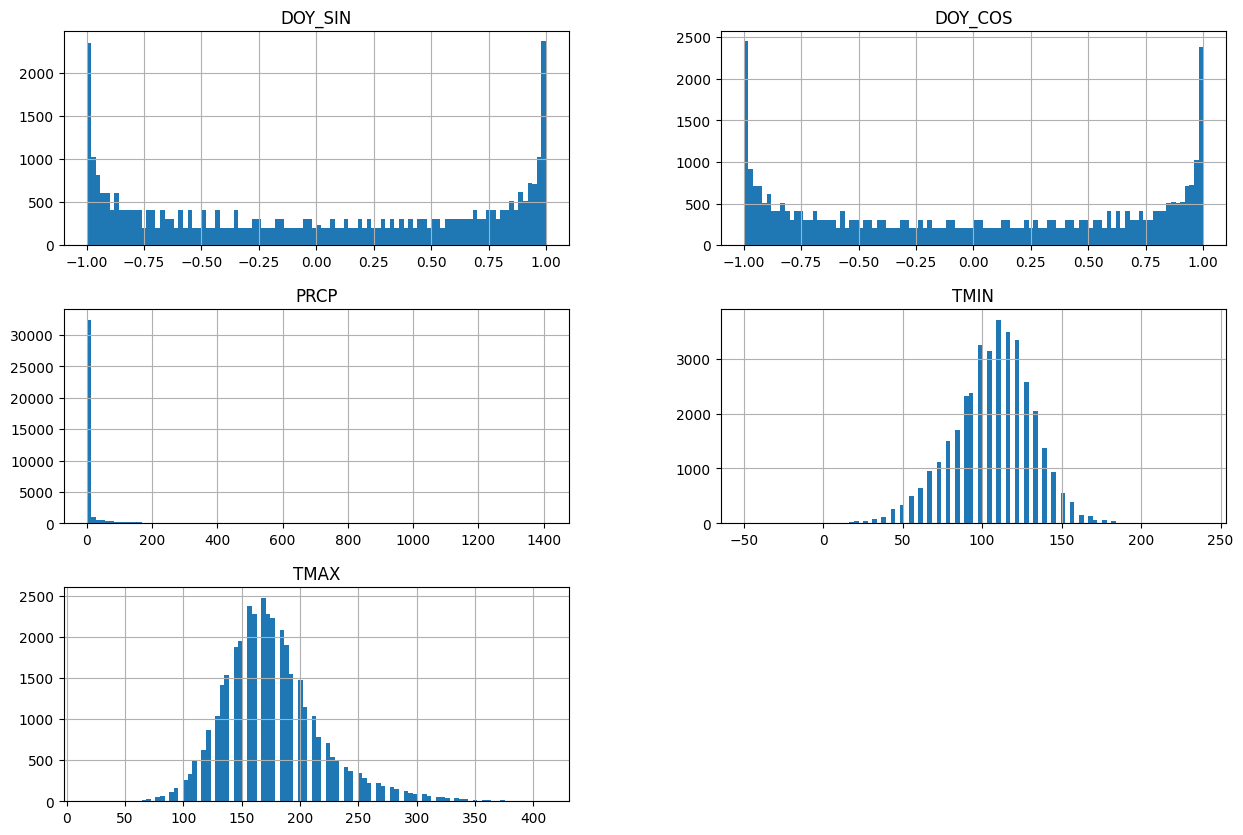

In [22]:
df_prcp_tmp.hist(bins=100, figsize=(15,10))

Some things to note is percipitation is heavily skewed right with most values being zero which may be a problem for normalization. The rest seem more or less fine. Google's tutorial also normalized the Fournier Transformations so I will do that too.

In [ ]:
n = len(df_prcp_tmp)
n

37355

I will repeat the process but with only the subset where WSFG windspeed is collected. As we can see below, this subset only runs from the first day of 1965 to the last day of 1974, which is exactly 10 years. I don't know why they stopped collecting wind speed afterward.

In [11]:
df_wsfg = df[df['WSFG'].notna()]
df_wsfg 

,STATION,DATE,PRCP,SNOW,SNWD,TMAX,TMIN,WDFG,WSFG
16070,USW00023272,1965-01-01,0.0,0.0,0.0,89.0,44.0,NaN,84.0
16071,USW00023272,1965-01-02,206.0,0.0,0.0,106.0,67.0,NaN,0.0
16072,USW00023272,1965-01-03,203.0,0.0,0.0,122.0,100.0,NaN,28.0
16073,USW00023272,1965-01-04,157.0,0.0,0.0,139.0,100.0,NaN,13.0
16074,USW00023272,1965-01-05,97.0,0.0,0.0,150.0,122.0,NaN,1.0
...,...,...,...,...,...,...,...,...,...
19717,USW00023272,1974-12-27,183.0,NaN,NaN,122.0,83.0,NaN,0.0
19718,USW00023272,1974-12-28,0.0,NaN,NaN,111.0,61.0,NaN,42.0
19719,USW00023272,1974-12-29,0.0,NaN,NaN,139.0,78.0,NaN,92.0
19720,USW00023272,1974-12-30,0.0,NaN,NaN,122.0,61.0,NaN,50.0


In [12]:
df_wsfg = df_wsfg.drop(['STATION', 'SNOW', 'SNWD', 'WDFG'], axis=1)
df_wsfg

,DATE,PRCP,TMAX,TMIN,WSFG
16070,1965-01-01,0.0,89.0,44.0,84.0
16071,1965-01-02,206.0,106.0,67.0,0.0
16072,1965-01-03,203.0,122.0,100.0,28.0
16073,1965-01-04,157.0,139.0,100.0,13.0
16074,1965-01-05,97.0,150.0,122.0,1.0
...,...,...,...,...,...
19717,1974-12-27,183.0,122.0,83.0,0.0
19718,1974-12-28,0.0,111.0,61.0,42.0
19719,1974-12-29,0.0,139.0,78.0,92.0
19720,1974-12-30,0.0,122.0,61.0,50.0


In [13]:
ws_dates = df_wsfg.pop("DATE")

In [14]:
ws_doy = pd.to_datetime(ws_dates).dt.dayofyear

In [15]:
df_wsfg["DOY_SIN"] = np.sin(ws_doy * (2 * np.pi / 365.2425))
df_wsfg["DOY_COS"] = np.cos(ws_doy * (2 * np.pi / 365.2425))
df_wsfg = df_wsfg[['DOY_SIN', 'DOY_COS', 'PRCP', 'WSFG', 'TMIN', 'TMAX']]
df_wsfg.head()

,DOY_SIN,DOY_COS,PRCP,WSFG,TMIN,TMAX
16070,0.017202,0.999852,0.0,84.0,44.0,89.0
16071,0.034399,0.999408,206.0,0.0,67.0,106.0
16072,0.051585,0.998669,203.0,28.0,100.0,122.0
16073,0.068757,0.997633,157.0,13.0,100.0,139.0
16074,0.085908,0.996303,97.0,1.0,122.0,150.0


array([[<Axes: title={'center': 'DOY_SIN'}>,
        <Axes: title={'center': 'DOY_COS'}>],
       [<Axes: title={'center': 'PRCP'}>,
        <Axes: title={'center': 'WSFG'}>],
       [<Axes: title={'center': 'TMIN'}>,
        <Axes: title={'center': 'TMAX'}>]], dtype=object)

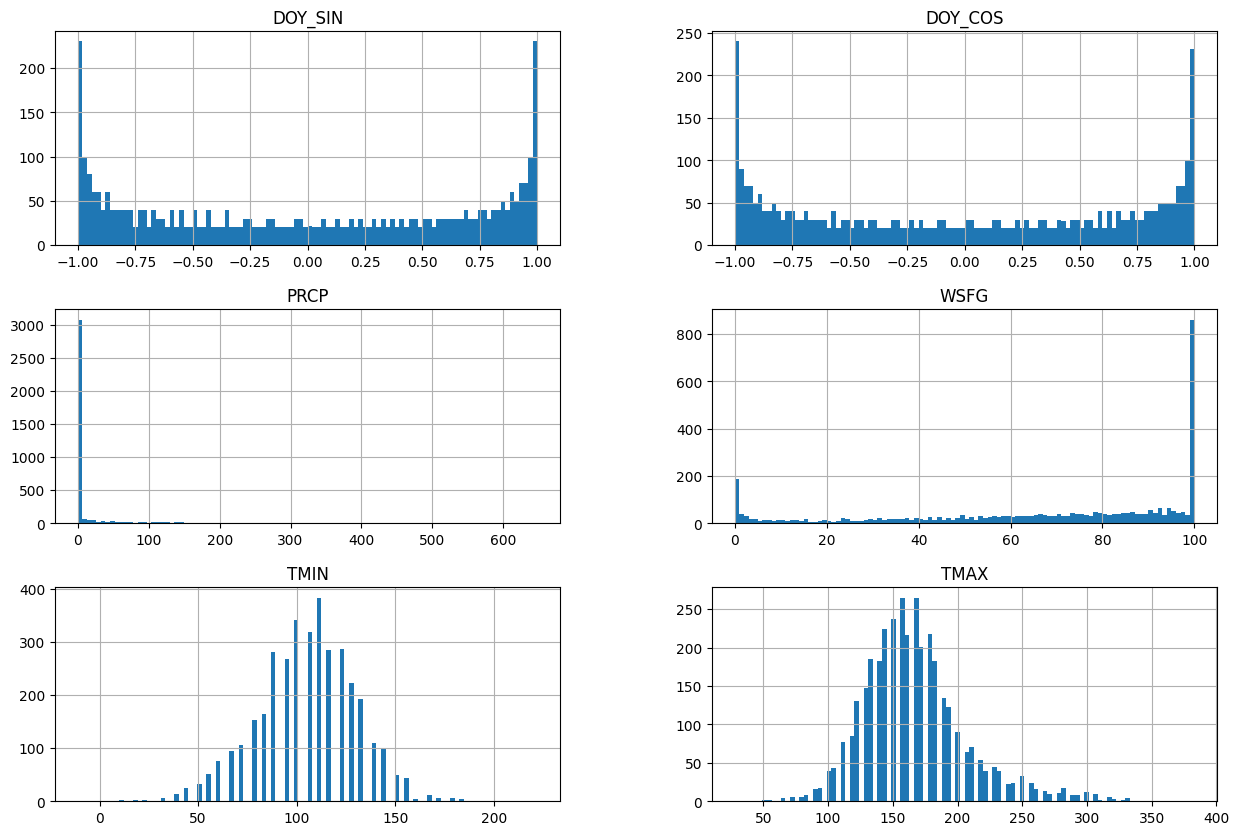

In [16]:
df_wsfg.hist(bins=100, figsize=(15,10))

Wind speed is at least not heavily skewed.

Now to transform the dataset to a timeseries data set for LSTM. I will include normalization and splitting process. I keep transformation information so I can convert the results back to original units which in this case will be TMIN (minimum temperature) and TMAX (maximum termpature). 

In [23]:
def print_dataset(ds):
    for inputs, targets in ds:
        print("---Batch---")
        print("Feature:", inputs.numpy())
        print("Label:", targets.numpy())
        print("")

In [24]:
class WindowData():
  def __init__(self, data, train_size, valid_size, test_size):
    self.data = data
    self.train_size = train_size
    self.valid_size = valid_size
    self.test_size = test_size
    self.train = None
    self.valid = None
    self.test = None
    self.tr_mean = None
    self.tr_sd = None
    self.baseline = None
  
  def data_split(self):
    n = len(self.data)
    train_ind = int(n*self.train_size)
    valid_ind = int(n*(self.train_size + self.valid_size))
    self.train = self.data[:train_ind]
    self.valid = self.data[train_ind:valid_ind]
    self.test = self.data[valid_ind:]
    self.baseline = self.data[valid_ind-1:-1]

  def normalize(self, fill=True):
    self.tr_mean = self.train.mean()
    self.tr_sd = self.train.std()
    self.train = (self.train - self.tr_mean)/self.tr_sd
    self.valid = (self.valid - self.tr_mean)/self.tr_sd
    self.test = (self.test - self.tr_mean)/self.tr_sd
    if fill:
      self.train = self.train.fillna(0)
      self.valid = self.valid.fillna(0)
      self.test = self.test.fillna(0)
  
  def ts_convert(self, features, label_slice, input_length, output_length, batch_size):
    def convert_helper(x):
      return x[:, :input_length, :], x[:, input_length:, label_slice]
    return tf.keras.preprocessing.timeseries_dataset_from_array(features, None, input_length + output_length, batch_size=batch_size).map(convert_helper)
  
  def ts_convert_all(self, label_slice, input_len, output_len, batch_size):
    self.ts_train = self.ts_convert(self.train, label_slice, input_len, output_len, batch_size)
    self.ts_valid = self.ts_convert(self.valid, label_slice, input_len, output_len, batch_size)
    self.ts_test = self.ts_convert(self.test, label_slice, input_len, output_len, batch_size)

In [57]:
windows = WindowData(df_prcp_tmp, 0.7, 0.2, 0.1)

In [58]:
windows.data_split()

In [59]:
windows.normalize()

In [60]:
windows.ts_convert_all(slice(3, None, None), 6, 1, 1)

In [25]:
ws_windows = WindowData(df_wsfg, 0.7, 0.2, 0.1)

In [26]:
ws_windows.data_split()

In [27]:
ws_windows.normalize()

In [28]:
ws_windows.ts_convert_all(slice(4, None, None), 6, 1, 1)

#Modeling

Here I'll try different LSTM models in TensorFlow Keras. Final layer is Dense 2 to predict TMIN and TMAX. Adam seems to be a good optimizer in most cases. I use mean squared error (MSE) for loss and mean absolute error (MAE) for model comparison. MAE is easier to interpret as it will be in the original units and it won't magnify the effects of large errors.

##Non-windspeed Models

In [55]:
model = tf.keras.Sequential([
    layers.LSTM(32, return_sequences=False),
    layers.Dense(2)
])


In [56]:
model.compile(loss="mse",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["mae"])

In [31]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=2,
                                                    mode='min')

In [58]:
history = model.fit(windows.ts_train, 
                    epochs=20,
                    validation_data=windows.ts_valid,
                    callbacks=[early_stopping])

Epoch 1/20
26142/26142 [==============================] - 152s 6ms/step - loss: 0.3209 - mae: 0.4186 - val_loss: 0.3783 - val_mae: 0.4686
Epoch 2/20
26142/26142 [==============================] - 148s 6ms/step - loss: 0.3044 - mae: 0.4077 - val_loss: 0.3698 - val_mae: 0.4610
Epoch 3/20
26142/26142 [==============================] - 142s 5ms/step - loss: 0.3013 - mae: 0.4053 - val_loss: 0.3664 - val_mae: 0.4583
Epoch 4/20
26142/26142 [==============================] - 137s 5ms/step - loss: 0.2994 - mae: 0.4038 - val_loss: 0.3634 - val_mae: 0.4555
Epoch 5/20
26142/26142 [==============================] - 138s 5ms/step - loss: 0.2979 - mae: 0.4028 - val_loss: 0.3615 - val_mae: 0.4534
Epoch 6/20
26142/26142 [==============================] - 134s 5ms/step - loss: 0.2967 - mae: 0.4019 - val_loss: 0.3603 - val_mae: 0.4517
Epoch 7/20
26142/26142 [==============================] - 133s 5ms/step - loss: 0.2955 - mae: 0.4011 - val_loss: 0.3595 - val_mae: 0.4505
Epoch 8/20
26142/26142 [==========

In [29]:
def metrics_plot(history):
    xs = np.arange(1, len(history['loss'])+1)
    plt.figure(figsize=[16,4])
    
    plt.subplot(1,3,1)
    plt.plot(xs, history['loss'], label='Training')
    plt.plot(xs, history['val_loss'], label='Validation')
    plt.xlabel('Epoch') 
    plt.ylabel('Loss') 
    plt.title('Loss')
    plt.legend()
    
    plt.subplot(1,3,2)
    plt.plot(xs, history['mae'], label='Training')
    plt.plot(xs, history['val_mae'], label='Validation')
    plt.xlabel('Epoch') 
    plt.ylabel('MAE')
    plt.title('MAE')
    plt.legend()
    plt.tight_layout()
    
    plt.show()

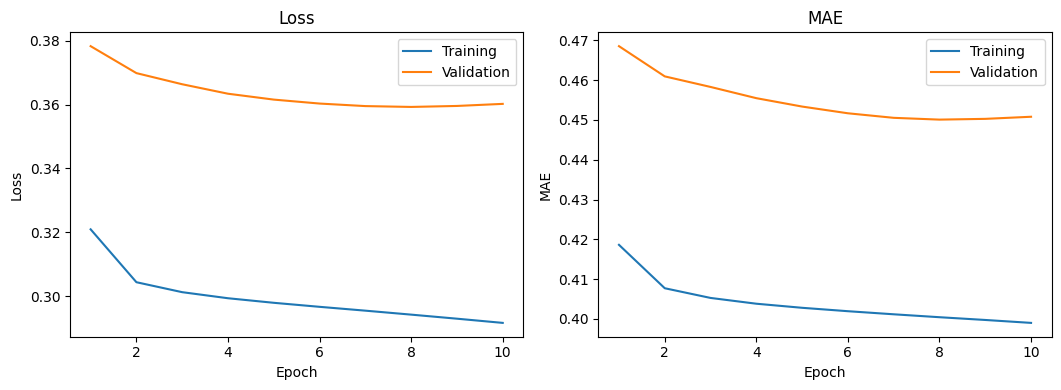

In [59]:
metrics_plot(history.history)

In [60]:
model.evaluate(windows.ts_test)

3730/3730 [==============================] - 11s 3ms/step - loss: 0.3157 - mae: 0.4248


[0.3157173693180084, 0.42476120591163635]

In [61]:
model2 = tf.keras.Sequential([
    layers.LSTM(32, return_sequences=False),
    layers.Dense(2)
])
model2.compile(loss="mse",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              metrics=["mae"])


In [62]:
history2 = model2.fit(windows.ts_train, 
                      epochs=20,
                      validation_data=windows.ts_valid,
                      callbacks=[early_stopping])

Epoch 1/20
26142/26142 [==============================] - 139s 5ms/step - loss: 0.3376 - mae: 0.4309 - val_loss: 0.4283 - val_mae: 0.5132
Epoch 2/20
26142/26142 [==============================] - 139s 5ms/step - loss: 0.3244 - mae: 0.4221 - val_loss: 0.4147 - val_mae: 0.4989
Epoch 3/20
26142/26142 [==============================] - 135s 5ms/step - loss: 0.3236 - mae: 0.4214 - val_loss: 0.4223 - val_mae: 0.5076
Epoch 4/20
26142/26142 [==============================] - 136s 5ms/step - loss: 0.3227 - mae: 0.4203 - val_loss: 0.4159 - val_mae: 0.5000


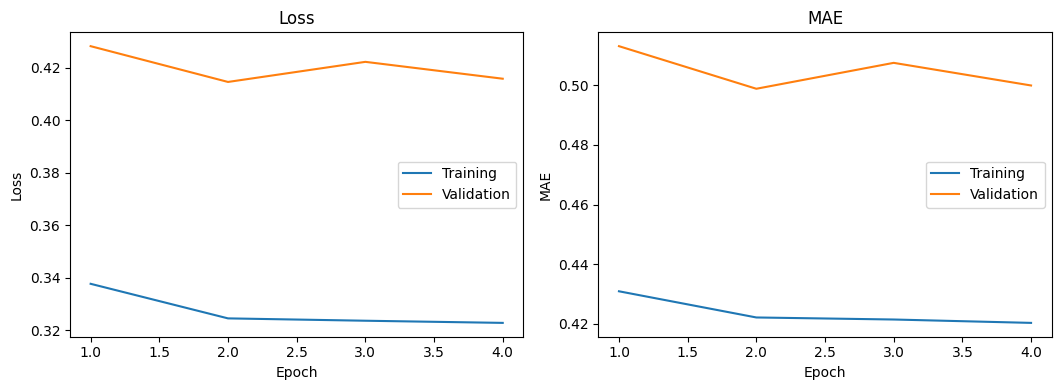

In [63]:
metrics_plot(history2.history)

In [64]:
model2.evaluate(windows.ts_test)

3730/3730 [==============================] - 11s 3ms/step - loss: 0.3570 - mae: 0.4640


[0.3570423424243927, 0.46404457092285156]

In [56]:
model3 = tf.keras.Sequential([
    layers.LSTM(16, return_sequences=False),
    layers.Dense(2)
])
model3.compile(loss="mse",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["mae"])

In [66]:
history3 = model3.fit(windows.ts_train, 
                      epochs=20,
                      validation_data=windows.ts_valid,
                      callbacks=[early_stopping])

Epoch 1/20
26142/26142 [==============================] - 142s 5ms/step - loss: 0.3270 - mae: 0.4227 - val_loss: 0.3732 - val_mae: 0.4652
Epoch 2/20
26142/26142 [==============================] - 138s 5ms/step - loss: 0.3036 - mae: 0.4071 - val_loss: 0.3708 - val_mae: 0.4628
Epoch 3/20
26142/26142 [==============================] - 138s 5ms/step - loss: 0.3011 - mae: 0.4052 - val_loss: 0.3674 - val_mae: 0.4595
Epoch 4/20
26142/26142 [==============================] - 136s 5ms/step - loss: 0.2994 - mae: 0.4040 - val_loss: 0.3646 - val_mae: 0.4569
Epoch 5/20
26142/26142 [==============================] - 138s 5ms/step - loss: 0.2982 - mae: 0.4032 - val_loss: 0.3633 - val_mae: 0.4558
Epoch 6/20
26142/26142 [==============================] - 137s 5ms/step - loss: 0.2972 - mae: 0.4026 - val_loss: 0.3628 - val_mae: 0.4555
Epoch 7/20
26142/26142 [==============================] - 135s 5ms/step - loss: 0.2964 - mae: 0.4021 - val_loss: 0.3627 - val_mae: 0.4555
Epoch 8/20
26142/26142 [==========

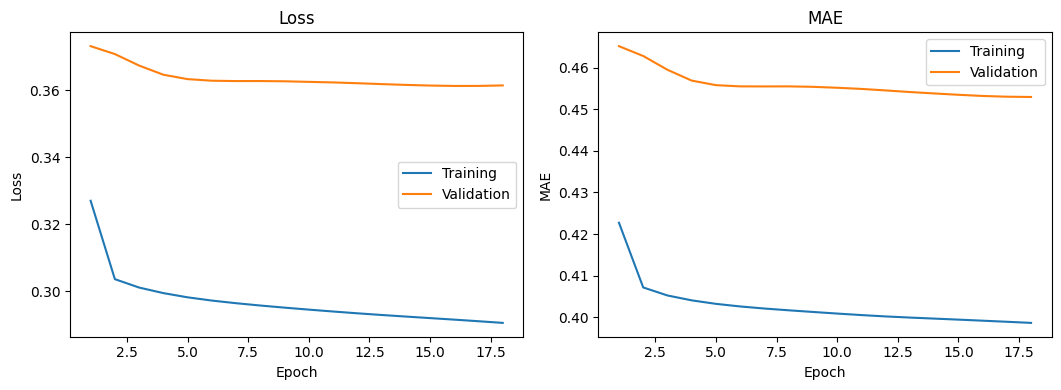

In [67]:
metrics_plot(history3.history)

In [68]:
model3.evaluate(windows.ts_test)

3730/3730 [==============================] - 10s 3ms/step - loss: 0.3185 - mae: 0.4282


[0.31845131516456604, 0.4281977117061615]

In [65]:
model4 = tf.keras.Sequential([
    layers.LSTM(64, return_sequences=False),
    layers.Dense(2)
])
model4.compile(loss="mse",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["mae"])

In [66]:
history4 = model4.fit(windows.ts_train, 
                      epochs=20,
                      validation_data=windows.ts_valid,
                      callbacks=[early_stopping])

Epoch 1/20
26142/26142 [==============================] - 147s 6ms/step - loss: 0.3203 - mae: 0.4188 - val_loss: 0.3765 - val_mae: 0.4667
Epoch 2/20
26142/26142 [==============================] - 145s 6ms/step - loss: 0.3045 - mae: 0.4078 - val_loss: 0.3694 - val_mae: 0.4610
Epoch 3/20
26142/26142 [==============================] - 145s 6ms/step - loss: 0.3011 - mae: 0.4051 - val_loss: 0.3640 - val_mae: 0.4555
Epoch 4/20
26142/26142 [==============================] - 162s 6ms/step - loss: 0.2988 - mae: 0.4035 - val_loss: 0.3629 - val_mae: 0.4542
Epoch 5/20
26142/26142 [==============================] - 146s 6ms/step - loss: 0.2972 - mae: 0.4023 - val_loss: 0.3622 - val_mae: 0.4536
Epoch 6/20
26142/26142 [==============================] - 143s 5ms/step - loss: 0.2958 - mae: 0.4013 - val_loss: 0.3609 - val_mae: 0.4527
Epoch 7/20
26142/26142 [==============================] - 146s 6ms/step - loss: 0.2943 - mae: 0.4002 - val_loss: 0.3603 - val_mae: 0.4520
Epoch 8/20
26142/26142 [==========

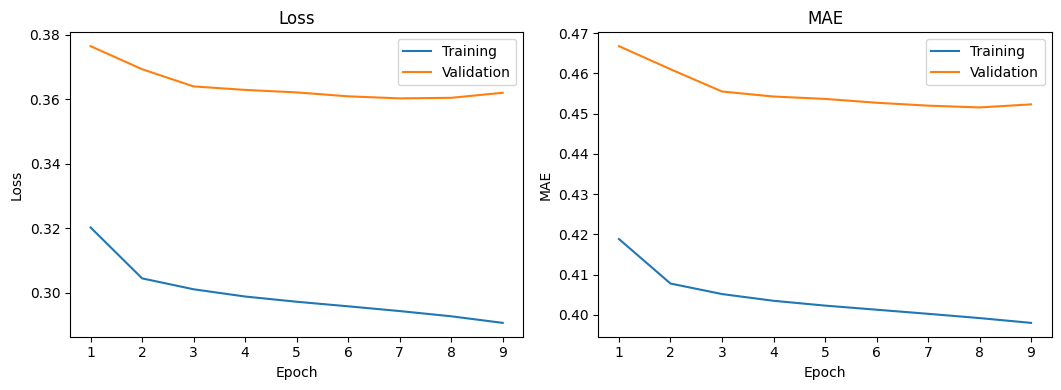

In [67]:
metrics_plot(history4.history)

In [68]:
model4.evaluate(windows.ts_test)

3730/3730 [==============================] - 12s 3ms/step - loss: 0.3172 - mae: 0.4260


[0.31720682978630066, 0.4260207712650299]

In [73]:
model5 = tf.keras.Sequential([
    layers.LSTM(64, return_sequences=False, activation="relu"),
    layers.Dense(2)
])
model5.compile(loss="mse",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["mae"])

In [74]:
history5 = model5.fit(windows.ts_train, 
                      epochs=20,
                      validation_data=windows.ts_valid,
                      callbacks=[early_stopping])

Epoch 1/20
26142/26142 [==============================] - 416s 16ms/step - loss: 0.3236 - mae: 0.4211 - val_loss: 0.3902 - val_mae: 0.4753
Epoch 2/20
26142/26142 [==============================] - 434s 17ms/step - loss: 0.3054 - mae: 0.4084 - val_loss: 0.3796 - val_mae: 0.4666
Epoch 3/20
26142/26142 [==============================] - 417s 16ms/step - loss: 0.3025 - mae: 0.4063 - val_loss: 0.3722 - val_mae: 0.4594
Epoch 4/20
26142/26142 [==============================] - 434s 17ms/step - loss: 0.3006 - mae: 0.4050 - val_loss: 0.3759 - val_mae: 0.4628
Epoch 5/20
26142/26142 [==============================] - 487s 19ms/step - loss: 0.2988 - mae: 0.4038 - val_loss: 0.3767 - val_mae: 0.4628


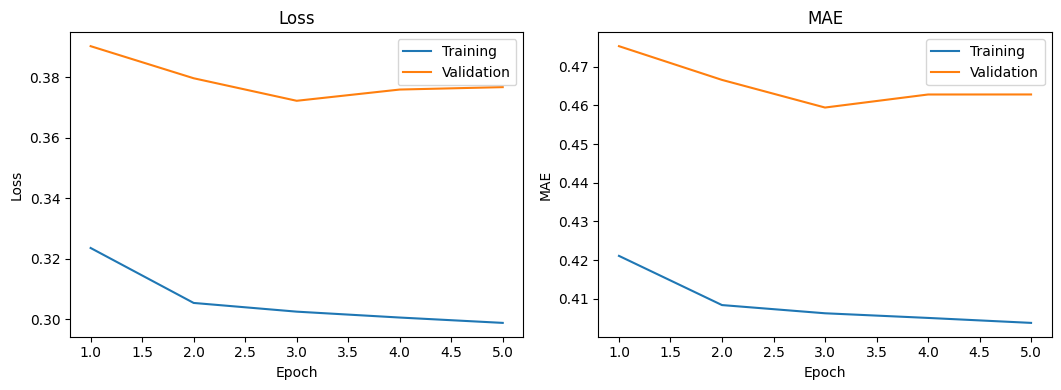

In [75]:
metrics_plot(history5.history)

In [76]:
model5.evaluate(windows.ts_test)

3730/3730 [==============================] - 16s 4ms/step - loss: 0.3240 - mae: 0.4328


[0.323963463306427, 0.4328085482120514]

##Windspeed Models

In [41]:
model6 = tf.keras.Sequential([
    layers.LSTM(32, return_sequences=False),
    layers.Dense(2)
])
model6.compile(loss="mse",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["mae"])

In [44]:
history6 = model6.fit(ws_windows.ts_train, 
                      epochs=20,
                      validation_data=ws_windows.ts_valid,
                      callbacks=[early_stopping])

Epoch 1/20
2549/2549 [==============================] - 23s 6ms/step - loss: 0.3940 - mae: 0.4706 - val_loss: 0.3596 - val_mae: 0.4400
Epoch 2/20
2549/2549 [==============================] - 15s 6ms/step - loss: 0.3220 - mae: 0.4234 - val_loss: 0.3397 - val_mae: 0.4267
Epoch 3/20
2549/2549 [==============================] - 14s 6ms/step - loss: 0.3125 - mae: 0.4156 - val_loss: 0.3349 - val_mae: 0.4223
Epoch 4/20
2549/2549 [==============================] - 15s 6ms/step - loss: 0.3071 - mae: 0.4115 - val_loss: 0.3321 - val_mae: 0.4203
Epoch 5/20
2549/2549 [==============================] - 14s 5ms/step - loss: 0.3028 - mae: 0.4084 - val_loss: 0.3297 - val_mae: 0.4186
Epoch 6/20
2549/2549 [==============================] - 14s 6ms/step - loss: 0.2989 - mae: 0.4056 - val_loss: 0.3285 - val_mae: 0.4176
Epoch 7/20
2549/2549 [==============================] - 15s 6ms/step - loss: 0.2952 - mae: 0.4029 - val_loss: 0.3283 - val_mae: 0.4172
Epoch 8/20
2549/2549 [==============================] -

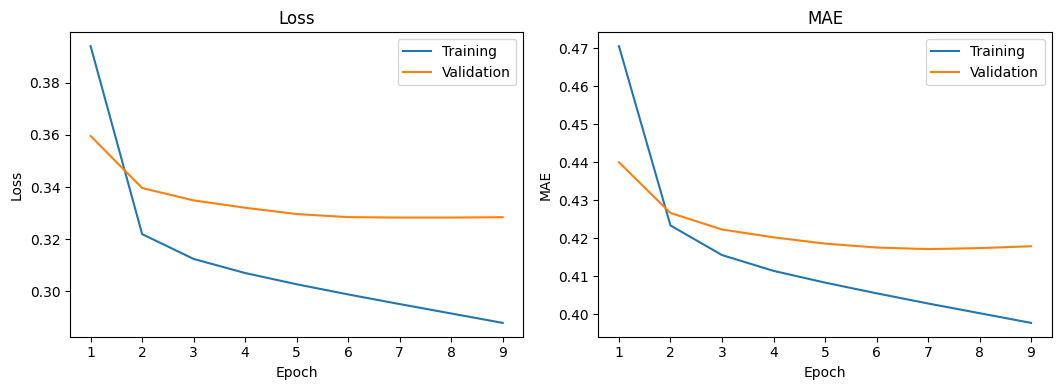

In [48]:
metrics_plot(history6.history)

In [49]:
model6.evaluate(ws_windows.ts_test)

360/360 [==============================] - 1s 3ms/step - loss: 0.3200 - mae: 0.4108


[0.31998947262763977, 0.41075173020362854]

In [51]:
model7 = tf.keras.Sequential([
    layers.LSTM(16, return_sequences=False),
    layers.Dense(2)
])
model7.compile(loss="mse",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["mae"])

In [52]:
history7 = model7.fit(ws_windows.ts_train, 
                      epochs=20,
                      validation_data=ws_windows.ts_valid,
                      callbacks=[early_stopping])

Epoch 1/20
2549/2549 [==============================] - 24s 8ms/step - loss: 0.4334 - mae: 0.4929 - val_loss: 0.3970 - val_mae: 0.4603
Epoch 2/20
2549/2549 [==============================] - 15s 6ms/step - loss: 0.3346 - mae: 0.4323 - val_loss: 0.3554 - val_mae: 0.4352
Epoch 3/20
2549/2549 [==============================] - 15s 6ms/step - loss: 0.3166 - mae: 0.4189 - val_loss: 0.3404 - val_mae: 0.4246
Epoch 4/20
2549/2549 [==============================] - 18s 7ms/step - loss: 0.3101 - mae: 0.4137 - val_loss: 0.3343 - val_mae: 0.4198
Epoch 5/20
2549/2549 [==============================] - 18s 7ms/step - loss: 0.3057 - mae: 0.4102 - val_loss: 0.3310 - val_mae: 0.4173
Epoch 6/20
2549/2549 [==============================] - 21s 8ms/step - loss: 0.3023 - mae: 0.4075 - val_loss: 0.3287 - val_mae: 0.4156
Epoch 7/20
2549/2549 [==============================] - 18s 7ms/step - loss: 0.2995 - mae: 0.4053 - val_loss: 0.3271 - val_mae: 0.4143
Epoch 8/20
2549/2549 [==============================] -

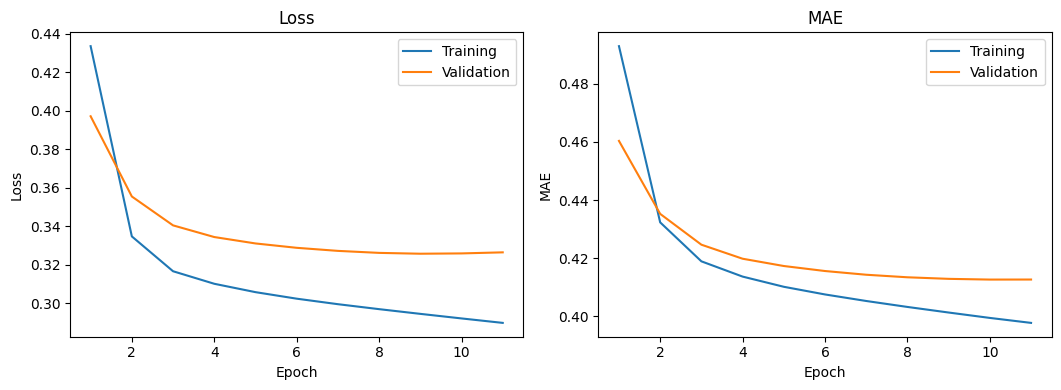

In [53]:
metrics_plot(history7.history)

In [54]:
model7.evaluate(ws_windows.ts_test)

360/360 [==============================] - 1s 3ms/step - loss: 0.3156 - mae: 0.4060


[0.3155633807182312, 0.4059929847717285]

In [33]:
model8 = tf.keras.Sequential([
    layers.LSTM(8, return_sequences=False),
    layers.Dense(2)
])
model8.compile(loss="mse",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["mae"])
history8 = model8.fit(ws_windows.ts_train, 
                      epochs=20,
                      validation_data=ws_windows.ts_valid,
                      callbacks=[early_stopping])

Epoch 1/20
2549/2549 [==============================] - 21s 7ms/step - loss: 0.4586 - mae: 0.5061 - val_loss: 0.4122 - val_mae: 0.4647
Epoch 2/20
2549/2549 [==============================] - 18s 7ms/step - loss: 0.3511 - mae: 0.4425 - val_loss: 0.3701 - val_mae: 0.4420
Epoch 3/20
2549/2549 [==============================] - 13s 5ms/step - loss: 0.3269 - mae: 0.4257 - val_loss: 0.3526 - val_mae: 0.4318
Epoch 4/20
2549/2549 [==============================] - 13s 5ms/step - loss: 0.3177 - mae: 0.4194 - val_loss: 0.3444 - val_mae: 0.4271
Epoch 5/20
2549/2549 [==============================] - 13s 5ms/step - loss: 0.3125 - mae: 0.4160 - val_loss: 0.3398 - val_mae: 0.4245
Epoch 6/20
2549/2549 [==============================] - 14s 5ms/step - loss: 0.3088 - mae: 0.4134 - val_loss: 0.3369 - val_mae: 0.4229
Epoch 7/20
2549/2549 [==============================] - 14s 5ms/step - loss: 0.3061 - mae: 0.4113 - val_loss: 0.3351 - val_mae: 0.4219
Epoch 8/20
2549/2549 [==============================] -

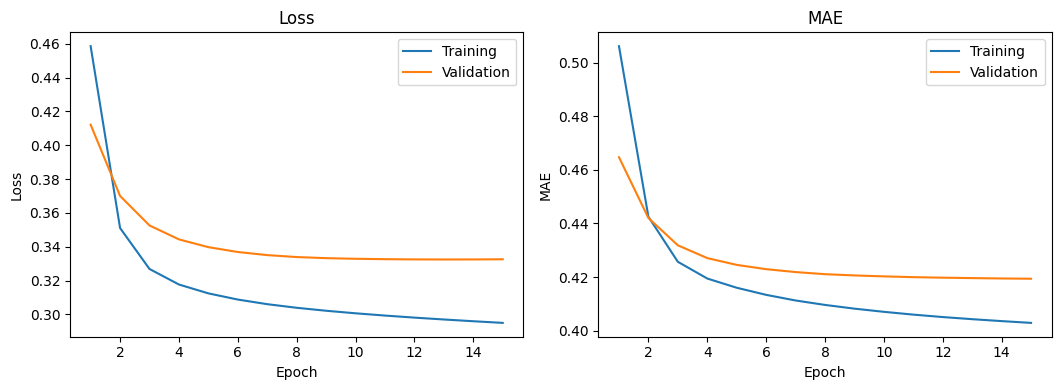

In [34]:
metrics_plot(history8.history)

In [35]:
model8.evaluate(ws_windows.ts_test)

360/360 [==============================] - 1s 3ms/step - loss: 0.3136 - mae: 0.4054


[0.31357109546661377, 0.4054127633571625]

##Baseline Comparison

Here I calculate the baseline MAE for each test set. To do this, I simply use the TMIN and TMAX measurements from the previous day.

In [48]:
normalized_baseline = (windows.baseline - windows.tr_mean)/windows.tr_sd
normalized_baseline.head()

,DOY_SIN,DOY_COS,PRCP,TMIN,TMAX
33618,0.402163,1.355355,-0.271104,-1.798237,-0.050672
33619,0.425408,1.348145,-0.271104,-1.118457,0.092052
33620,0.448526,1.340536,-0.271104,-1.558315,-0.050672
33621,0.471509,1.332532,-0.271104,-1.358380,0.092052
33622,0.494351,1.324133,-0.271104,-1.358380,-0.050672


In [52]:
normalized_diff = normalized_baseline.reset_index() - windows.test.reset_index()
normalized_diff.head()

,index,DOY_SIN,DOY_COS,PRCP,TMIN,TMAX
0,-1,-0.023245,0.007210,0.0,-0.679780,-0.142725
1,-1,-0.023118,0.007609,0.0,0.439858,0.142725
2,-1,-0.022983,0.008005,0.0,-0.199935,-0.142725
3,-1,-0.022842,0.008399,0.0,0.000000,0.142725
4,-1,-0.022694,0.008790,0.0,-0.439858,0.261662


In [54]:
(normalized_diff.TMIN.abs().sum() + normalized_diff.TMAX.abs().sum())/(len(normalized_diff)*2)

0.4342070136828859

In [55]:
ws_normalized_baseline = (ws_windows.baseline - ws_windows.tr_mean)/ws_windows.tr_sd
ws_normalized_diff = ws_normalized_baseline.reset_index() - ws_windows.test.reset_index()
(ws_normalized_diff.TMIN.abs().sum() + ws_normalized_diff.TMAX.abs().sum())/(len(ws_normalized_diff)*2)

0.45497127860530495

MAE for non-windspeed set is 0.4342 and 0.4550 for windspeed set.

# Results

These tables and graphs are not auto-generated, but based on my most recent run just so my analysis can be consistent with it.

Non-windspeed models:

|Model|Description|Epochs|Train MAE|Validation MAE|Test MAE|
|----|----|----|---|---|----|
|baseline|t-1 as pred| | | |0.4342|
|model1|LSTM(32) lr=0.001|10 |0.4004 | 0.4501 | 0.4248|
|model2|LSTM(32) lr=0.01|4|0.4203 | 0.5000 | 0.4640|
|model3|LSTM(16) lr=0.001|18|0.3986 |  0.4530 | 0.4282|
|model4|LSTM(64) lr=0.001|9|0.3980 |  0.4523 | 0.4260|
|model5|LSTM(64) lr=0.001 actiavtion="relu"|5|0.4038 |  0.4628 |0.4328|

<Axes: xlabel='model'>

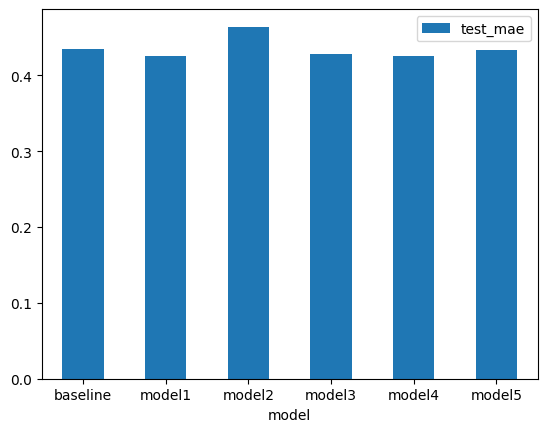

In [105]:
test_mae = {'model':['baseline', 'model1', 'model2', 'model3', 'model4', 'model5'], 'test_mae':[0.4342, 0.4248, 0.4640, 0.4282, 0.4260, 0.4328]}

pd.DataFrame(test_mae).plot.bar(x='model', y='test_mae', rot=0)

We can see that these models barely beat out the baseline model in MAE. This suggests that the test set could be sufficiently different from the training set as the years are a lot later and with climate change effects. My models architecture could also be insufficient. Another explanation is that these features do not explain the labels enough especially since percipitation is not very helpful to explain much in San Francisco.

Windspeed models:

|Model|Description|Epochs|Train MAE|Validation MAE|Test MAE|
|----|----|----|---|---|----|
|ws_baseline|t-1 as pred| | | |0.4550|
|model6|LSTM(32) lr=0.001|9|0.3978 |  0.4179 | 0.4108|
|model7|LSTM(16) lr=0.001|11|0.3977 |  0.4127 | 0.4060|
|model8|LSTM(8) lr=0.001|15|0.4029 |  0.4194 | 0.4054|

<Axes: xlabel='ws_model'>

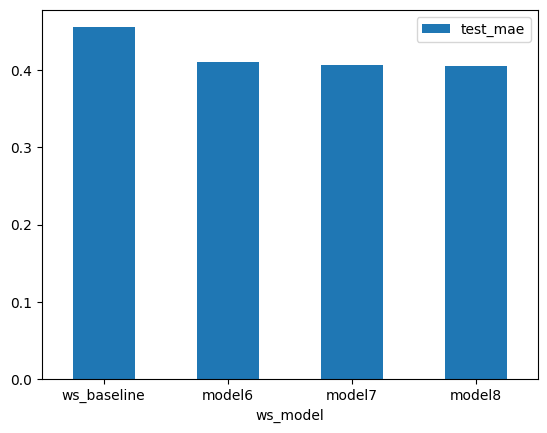

In [36]:
ws_test_mae = {'ws_model':['ws_baseline', 'model6', 'model7', 'model8'], 'test_mae':[0.4550, 0.4108, 0.4060, 0.4054]}

pd.DataFrame(ws_test_mae).plot.bar(x='ws_model', y='test_mae', rot=0)

Here we can see that adding a feature that better explains the label increases performance noticeably. It also helps that the year ranges are a lot more restricted where the windspeed dataset was constrained to a 10 year period vs a 100 year period in the non-windspeed dataset. It is also noted that less LSTM units very slightly improved the MAE scores. If this dataset contained more helpful features I believe LSTM could do an even better job out performing the baseline. 

##Real World Intepretation

Using model7 from the windspeed dataset, we'll see how what these results actually mean in terms of a real application. We'll see what the model predicts for the first sample in the test set.

In [69]:
predicts = model7.predict(ws_windows.ts_test)

360/360 [==============================] - 1s 2ms/step


In [78]:
actual_1 = next(iter(ws_windows.ts_test))
actual_1

(<tf.Tensor: shape=(1, 6, 6), dtype=float64, numpy=
 array([[[-5.41908188e-03,  1.41455890e+00,  1.04512004e+00,
          -2.22764328e+00, -1.53431669e+00, -1.49782935e+00],
         [ 2.48015116e-02,  1.41436199e+00, -2.84912279e-01,
           8.02836863e-01, -1.77304873e+00, -1.64361252e+00],
         [ 4.91165029e-02,  1.41373441e+00, -2.84912279e-01,
           8.99554315e-01, -2.44945620e+00, -1.91088166e+00],
         [ 7.34171010e-02,  1.41268865e+00,  6.82874545e+00,
          -2.22764328e+00, -2.88713161e+00, -2.32393398e+00],
         [ 9.76961148e-02,  1.41122501e+00,  8.83904005e-01,
          -3.53810481e-02, -2.44945620e+00, -2.44541995e+00],
         [ 1.21946359e-01,  1.40934394e+00, -2.29362154e-02,
          -6.47924907e-01, -2.21072415e+00, -1.78939569e+00]]])>,
 <tf.Tensor: shape=(1, 1, 2), dtype=float64, numpy=array([[[-2.21072415, -2.17815081]]])>)

In [70]:
predicts[0]

array([-1.7249043, -1.4676483], dtype=float32)

It predicts -1.725 for TMIN and -1.468 for TMAX, but these are normalized values and in 10th of a degree Celcius. Since we use fahrenheit in the US, I'll convert it to those units.

These were the means and standard deviations from the training set which were used to normalized the rest of the data.

In [73]:
ws_windows.tr_sd

DOY_SIN     0.707252
DOY_COS     0.707238
PRCP       49.622854
WSFG       31.018187
TMIN       25.132780
TMAX       41.157014
dtype: float64

In [80]:
ws_windows.tr_mean

DOY_SIN     -0.000339
DOY_COS     -0.000438
PRCP        14.138160
WSFG        69.097456
TMIN       105.561644
TMAX       167.646184
dtype: float64

Now to convert:

In [84]:
(predicts[0][0]*ws_windows.tr_sd['TMIN'] + ws_windows.tr_mean['TMIN'])*0.1*9/5 + 32

43.19780062692008

In [85]:
(predicts[0][1]*ws_windows.tr_sd['TMAX'] + ws_windows.tr_mean['TMAX'])*0.1*9/5 + 32

51.30358938477088

Our model predicts a TMIN of 43.2 and TMAX of 51.3 degrees F for the day.

In [97]:
(float(actual_1[1][0][0][0])*ws_windows.tr_sd['TMIN'] + ws_windows.tr_mean['TMIN'])*0.1*9/5 + 32

41.0

In [96]:
(float(actual_1[1][0][0][1])*ws_windows.tr_sd['TMAX'] + ws_windows.tr_mean['TMAX'])*0.1*9/5 + 32

46.040000000000006

Actual TMIN was 41.0 and TMAX was 46.04 degrees F. We can see it does less well on TMAX, but that's to be expected since TMAX has a higher standard deviation in SF.

Looking at Mean Absolute Error (MAE) for comparison:

In [75]:
0.4060*ws_windows.tr_sd['TMIN']*0.1*9/5

1.836703566229015

In [76]:
0.4060*ws_windows.tr_sd['TMAX']*0.1*9/5

3.00775460311772

In [98]:
0.4550*ws_windows.tr_sd['TMIN']*0.1*9/5

2.0583746862911374

In [99]:
0.4550*ws_windows.tr_sd['TMAX']*0.1*9/5

3.3707594690112375

Our model on average was incorrect by 1.84 and 3.01 degrees F for TMIN and TMAX, while the baseline was off by 2.06 and 3.37 degrees F for TMIN and TMAX. Those are small and likely unnoticeable differences for the average daily user and a reasonable improvement given that likely on windspeed was a good feature. 

If I had better features, these models could produce much better results like in the TensorFlow tutorial, but one major advantage this has over the tensorflow dataset is that it can give location based forecasting where the tesnorlfow dataset cannot.

#Future Work

I could definitely try tweaking models more to see if I can find an architecture that better fits the data and I could also find better data or try to engineer better features. 

I could also see how it performs using different batches or using a bigger sequence like 2 weeks to predict one day or use it to predict a standard 7 day forecast and here it will very likely heavily outperform a baseline model that just predicts the previous day for the next 7. 

#References:

https://mobiarch.wordpress.com/2020/11/13/preparing-time-series-data-for-rnn-in-tensorflow/

https://www.tensorflow.org/tutorials/structured_data/time_series